# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true, y_pred):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    nfpr, ntpr, thresholds = roc_curve(y_true, ns_probs)
    ns_auc = auc(nfpr, ntpr)
    lr_auc = auc(fpr, tpr)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Logistic: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='0.5')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y_p, y, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder = 'oboa\\'
saveModel = 'RF_Models\\'
filename = 'oboa-e11.pkl'

X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

clf = RandomForestClassifier(n_estimators=500, min_samples_split=8, min_samples_leaf=12, max_features='sqrt', max_depth=15, verbose=2, n_jobs=2)

In [4]:
clf.fit(X_train, y_train)
pickle.dump(clf, open(saveModel+filename, 'wb'))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  8.7min


building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 32.0min


building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500


[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 68.6min


building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 95.6min finished


# Test Set

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   22.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   51.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  1.2min finished


Best Threshold=0.401525
Logistic: ROC AUC=0.998
Logistic: ROC AUC=0.500


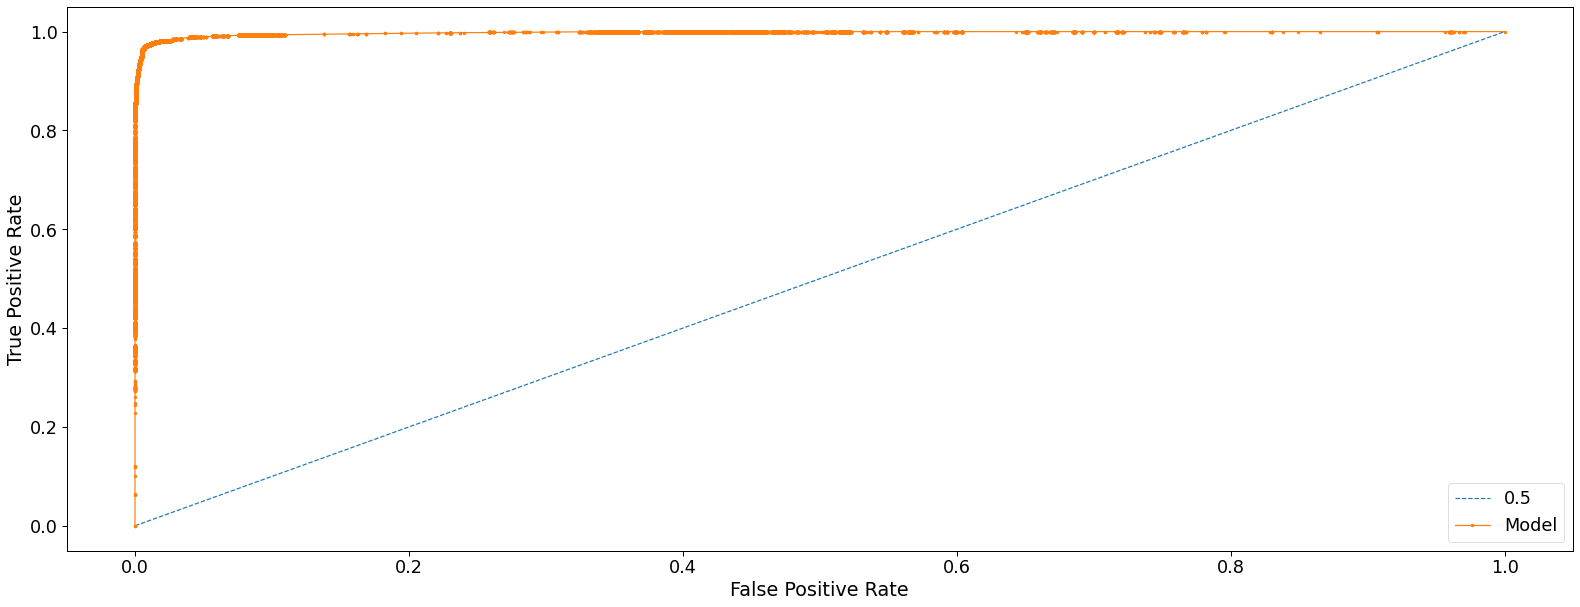

[[1266222   12033]
 [  35241 1243014]]


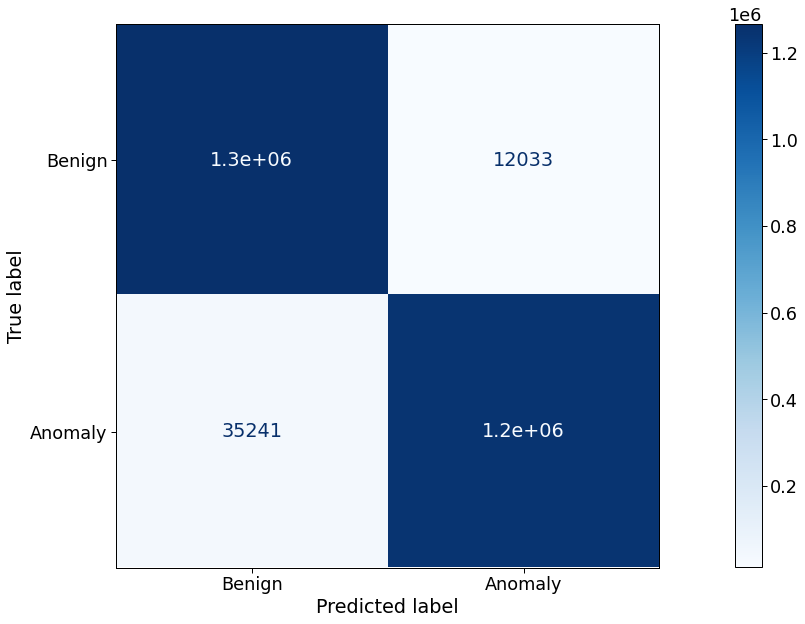

accuracy:  0.9815083844772756
f1:  0.9813389797189597
precision:  0.9904123112520886
recall:  0.9724303836089043
mcc:  0.9631755328228804


In [5]:
X_1 = np.load(folder+'X_test.npy')
y_1 = np.load(folder+'y_test.npy')

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)

# Full Test Set

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   29.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  6.4min finished


Best Threshold=0.199751
Logistic: ROC AUC=0.712
Logistic: ROC AUC=0.500


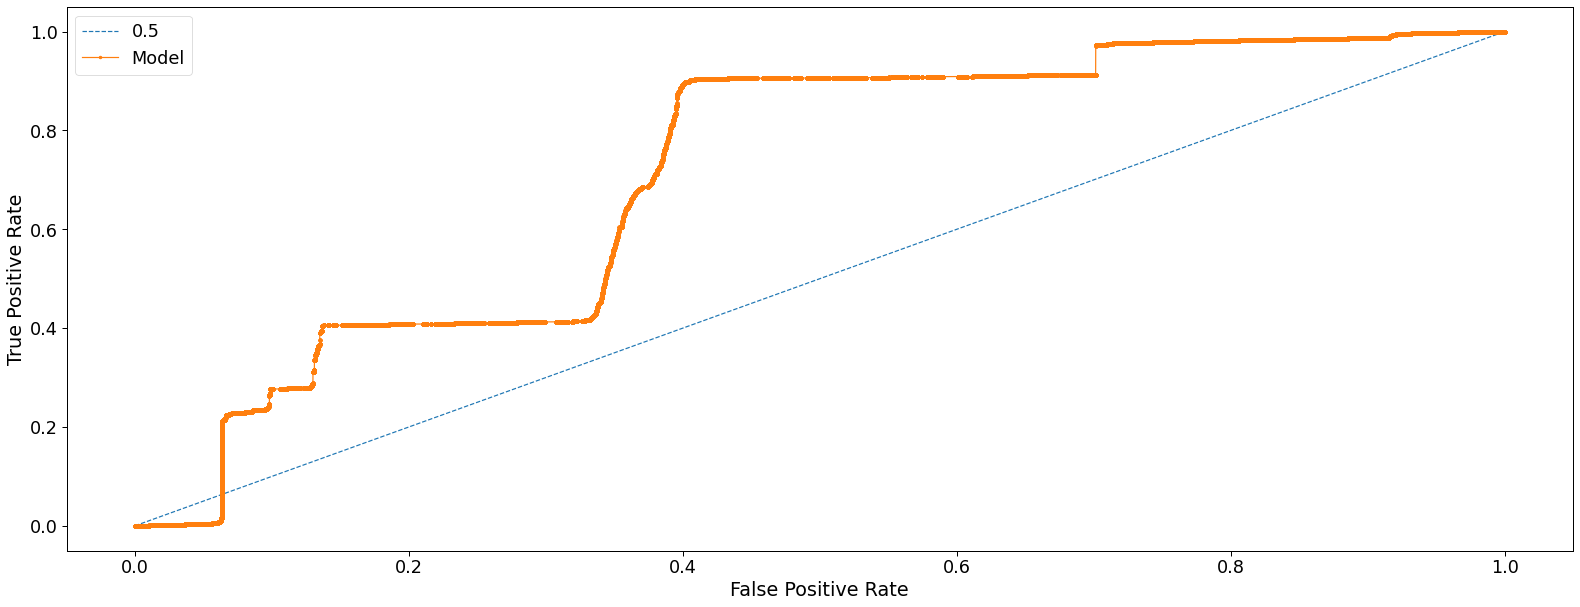

[[9665691  705055]
 [1724288  500216]]


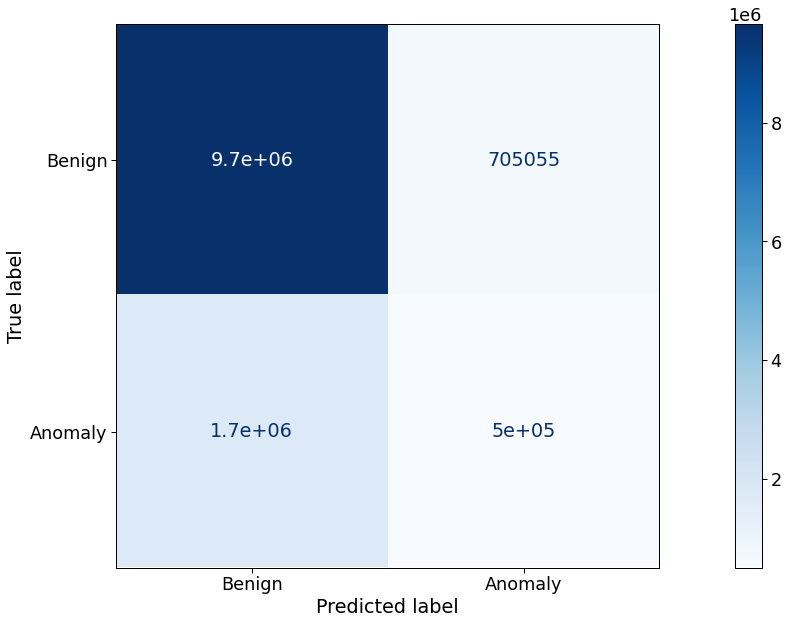

accuracy:  0.8071222881641889
f1:  0.29169027122770447
precision:  0.4150236751734672
recall:  0.22486630727568932
mcc:  0.20337099958338528
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          1                       2094
Brute Force -XSS          1                        895
DDOS attack-HOIC          1                    1080858
DDoS attacks-LOIC-HTTP    0                          5
                          1                     280332
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  1                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      22290
                          1                       3643
Infilteration             0                      10454
                          1                     103872
SQL Injection             1                  

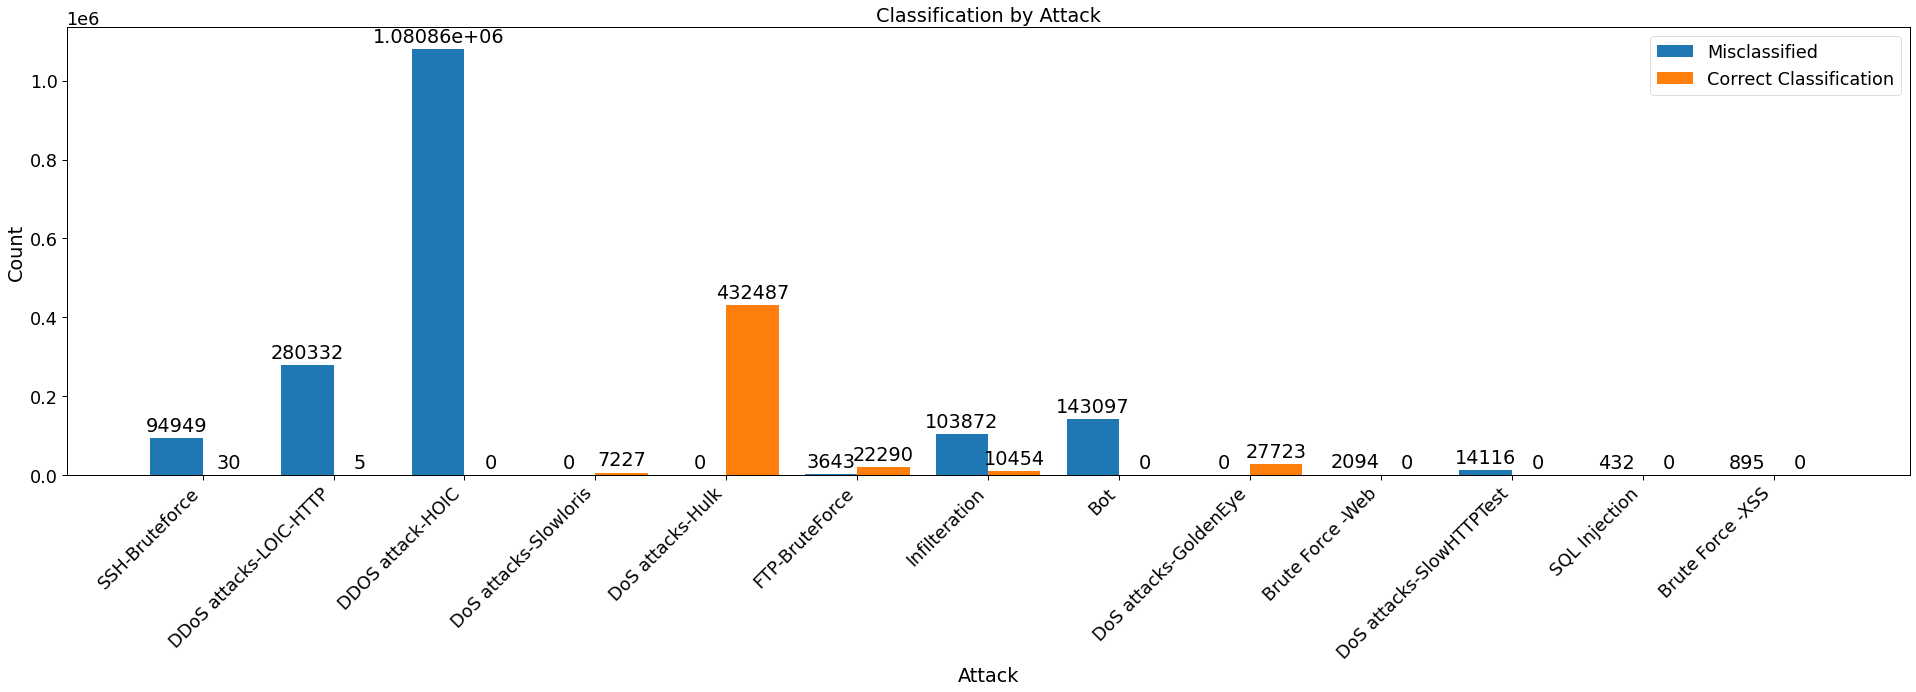

In [6]:
X_1 = np.load(folder+'X_1.npy')
y_1 = np.load(folder+'y_1.npy')
a_1 = np.load(folder+'a_1.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

# Full Test Set with Threshold

Best Threshold=0.199751
[[6157297 4213449]
 [ 217150 2007354]]


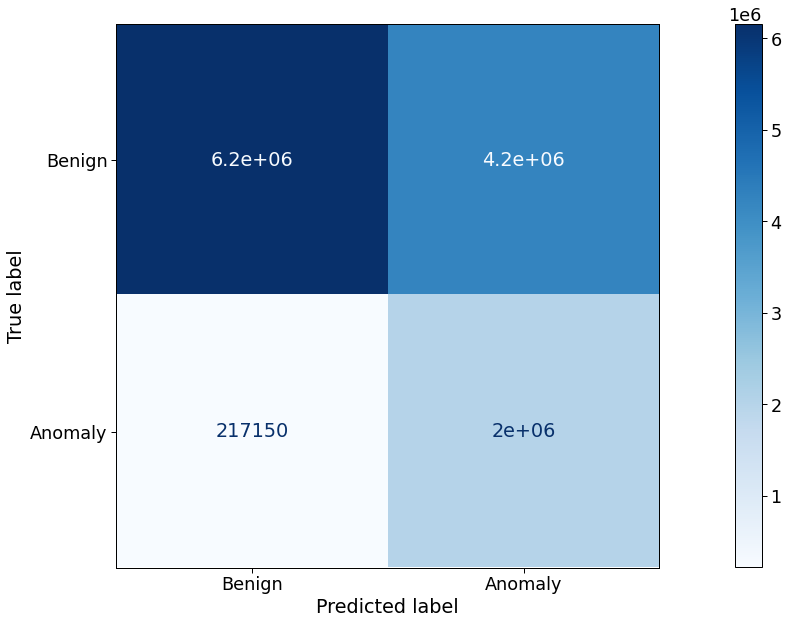

accuracy:  0.6482325479843591
f1:  0.4753773900700117
precision:  0.322684065063626
recall:  0.9023827334093353
mcc:  0.378396272080692
attack                    misclassification
Bot                       0                        778
                          1                     142319
Brute Force -Web          0                       2080
                          1                         14
Brute Force -XSS          0                        883
                          1                         12
DDOS attack-HOIC          0                    1076826
                          1                       4032
DDoS attacks-LOIC-HTTP    0                     280337
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                      4

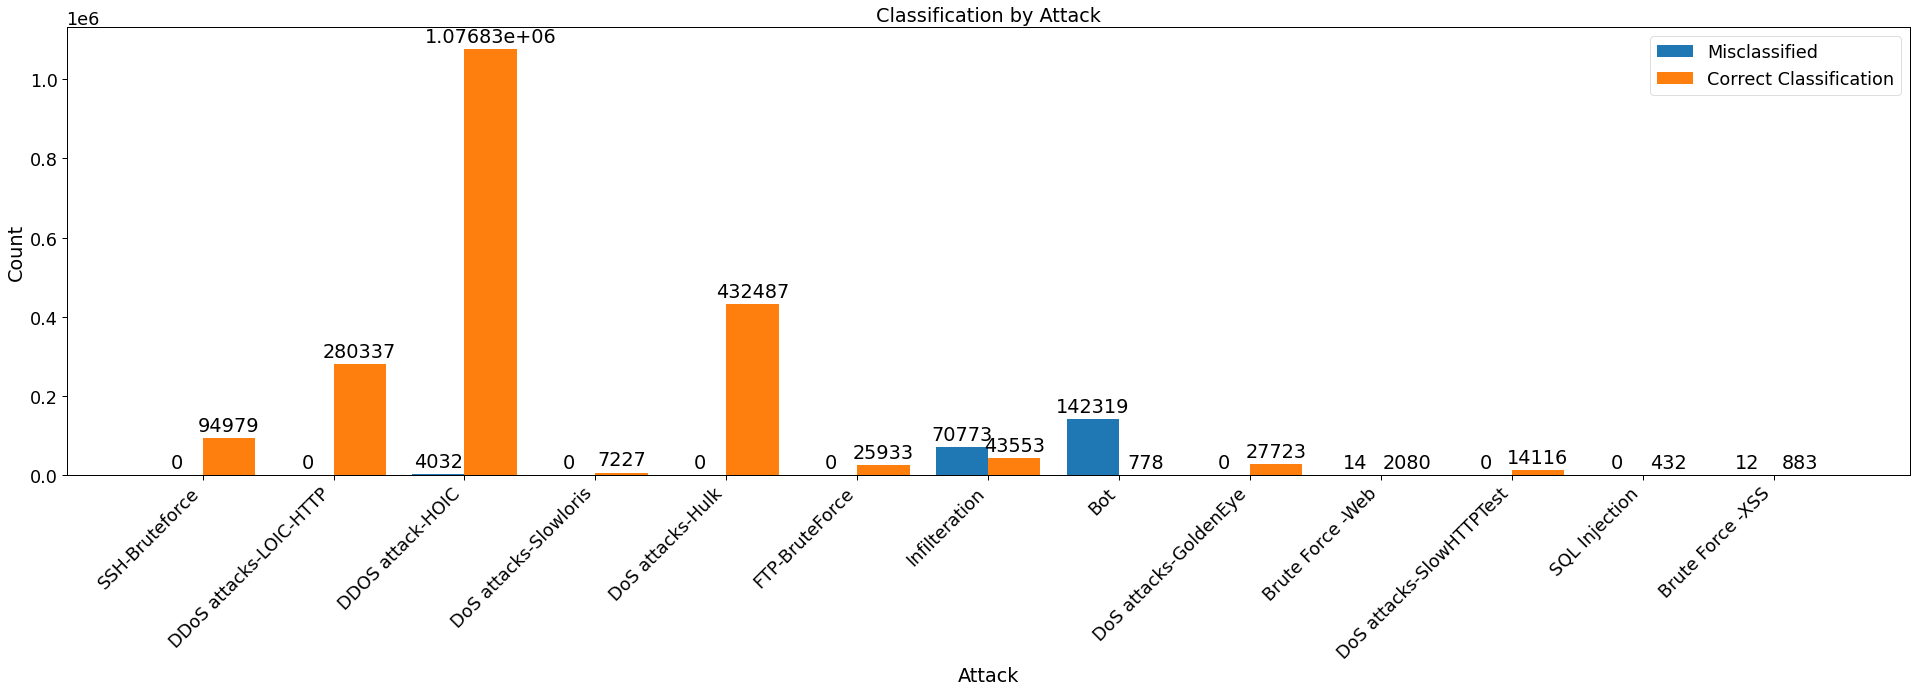

In [7]:
print('Best Threshold=%f' % (best_thresh))
y_pred2 = np.where(y_pred_o > best_thresh, 1, 0)
test_report(y_1 ,y_pred2)
attack_report(y_pred2, y_1, a_1)

# Test Set AR

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   25.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  5.6min finished


Best Threshold=0.391775
Logistic: ROC AUC=0.851
Logistic: ROC AUC=0.500


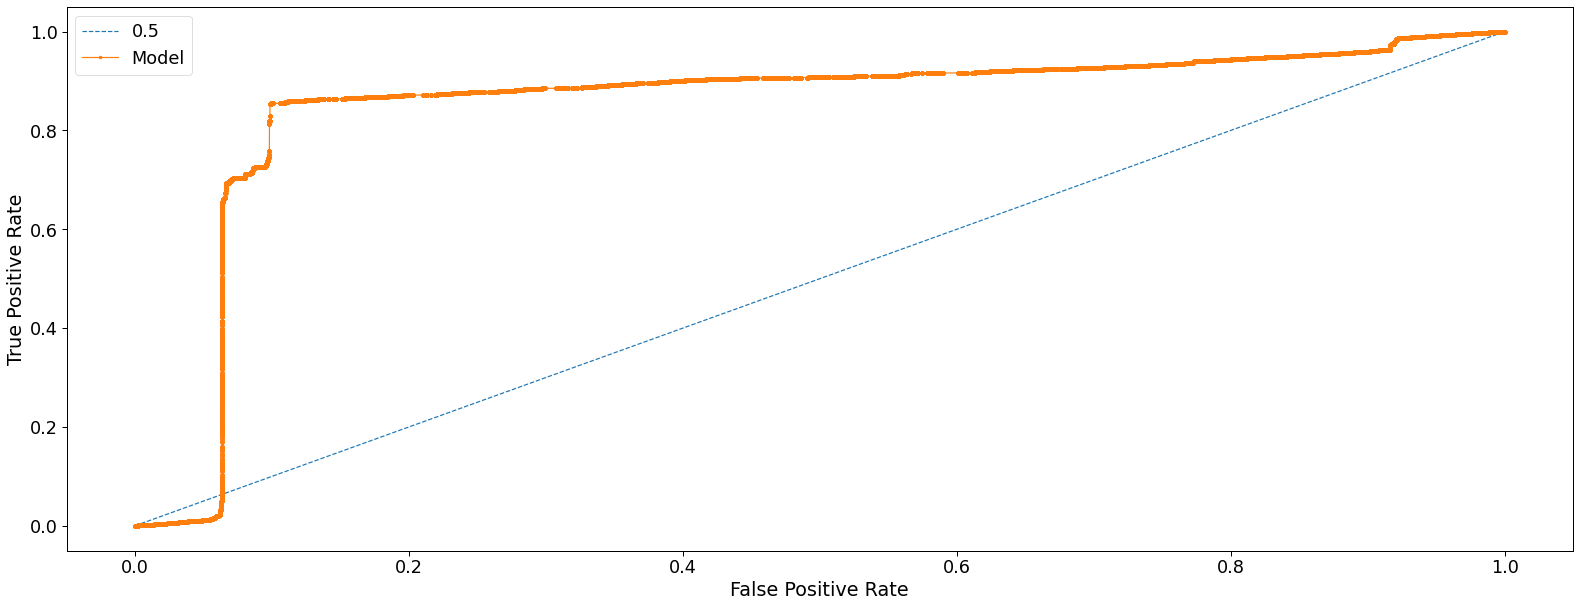

[[9665691  705055]
 [ 220001  500211]]


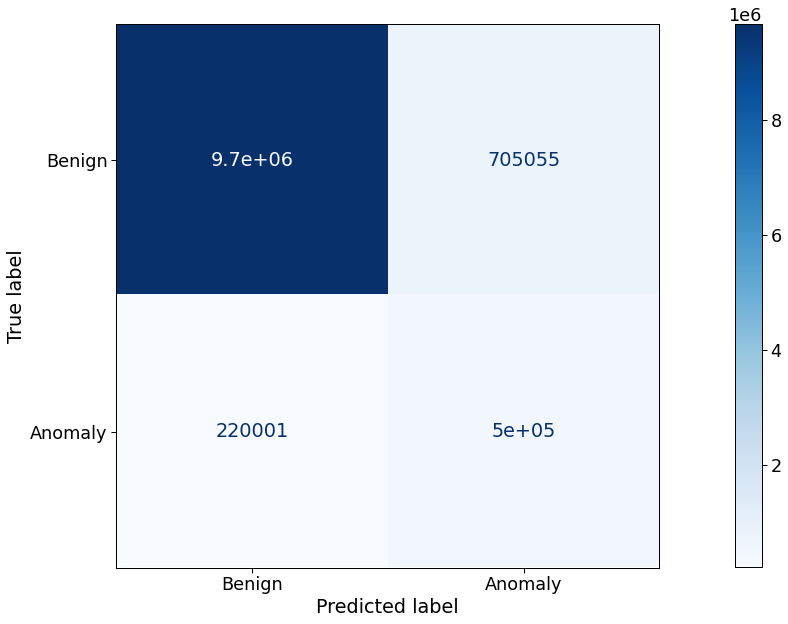

accuracy:  0.916593679283611
f1:  0.5195707247758738
precision:  0.4150212484215103
recall:  0.6945329986170738
mcc:  0.49607180414667285
attack                    misclassification
Brute Force -Web          1                      2094
Brute Force -XSS          1                       895
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432487
DoS attacks-SlowHTTPTest  1                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            0                     22290
                          1                      3643
Infilteration             0                     10454
                          1                    103872
SQL Injection             1                       432
SSH-Bruteforce            0                        30
                          1                     94949
dtype: int64
[30, 94949]
[7227]
[432487]
[22290, 3643]
[10454, 103872]
[27723]
[2094]
[14116]
[432]
[895]


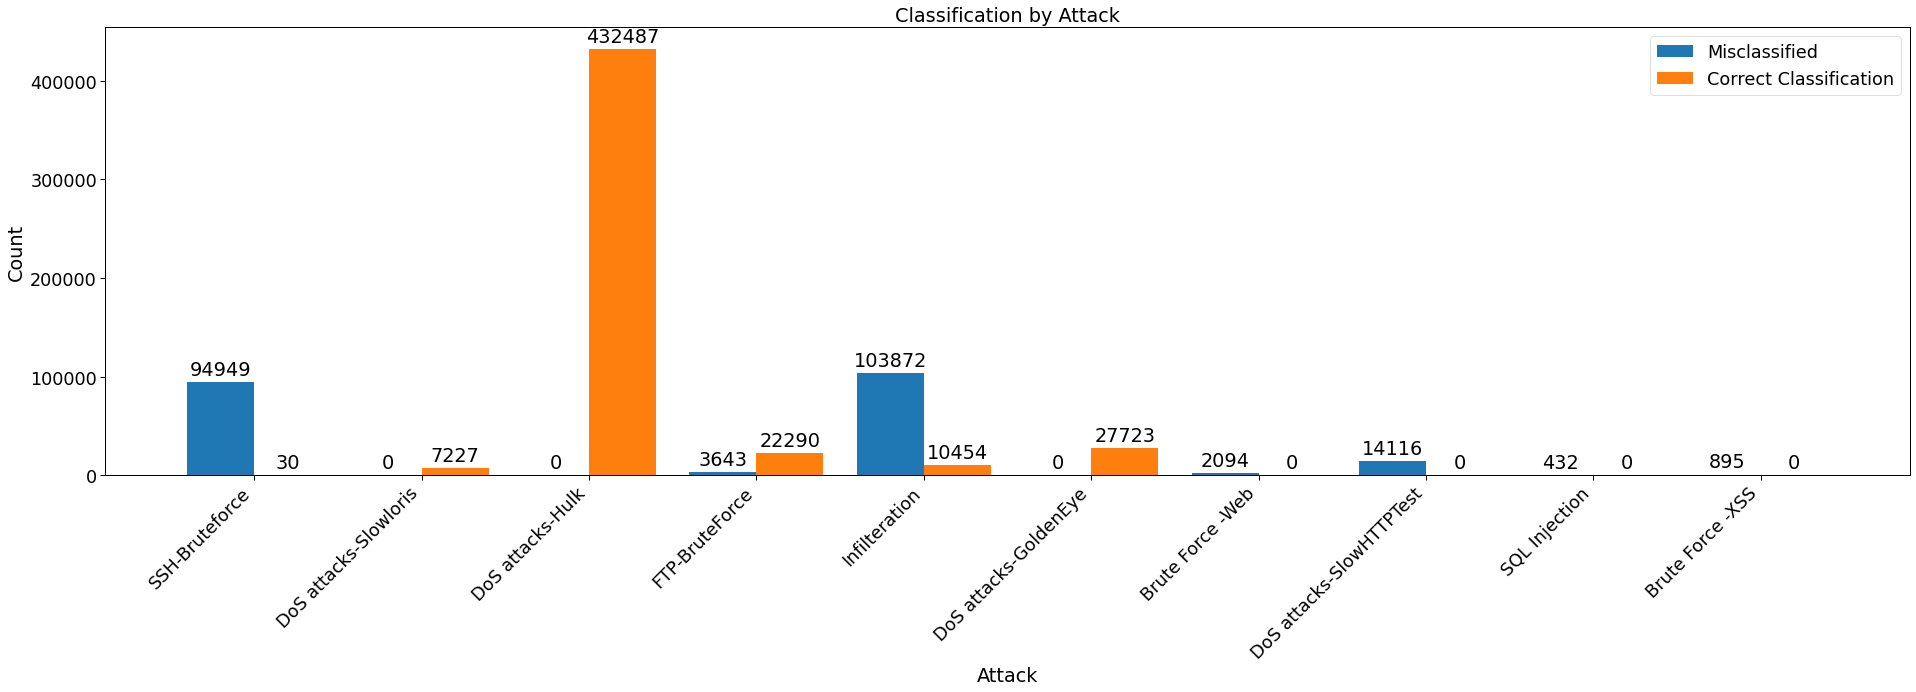

In [8]:
X_1 = np.load(folder+'X_1_ar.npy')
y_1 = np.load(folder+'y_1_ar.npy')
a_1 = np.load(folder+'a_1_ar.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]

fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)